# 全卷积神经网络

In [3]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 加载预训练模型

In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
#取最后三层
#最后两层全局平均池化和线性层用不到，去掉
#children()用来获取网络的各层
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

## 修改预训练模型最后两层

In [3]:
#去掉ResNet最后两层
#左闭右开
#list将各层转化成一个列表
#*将list变量拆成多个独立的参数，传入函数
net=nn.Sequential(*list(pretrained_net.children())[:-2])
X=torch.rand(size=(1,3,320,480))
#尺寸缩小了32倍
net(X).shape

torch.Size([1, 512, 10, 15])

In [11]:
#测试 左闭右开
x=torch.tensor([1,2,3,4])
x=x[1:3]
print(x)

tensor([2, 3])


In [12]:
#使用1×1卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。 将要素地图的高度和宽度增加32倍
num_classes=21
net.add_module('final_conv',nn.Conv2d(512,num_classes,kernel_size=1))
#因为宽度和高度要增加32倍，所以stride=32,kernel_size选择64是这样正好窗口是有一半是重叠的，padding其实按照卷积来说应该取32，但是如果剩下的不够，
#剩下的卷积核是不会再取，为了减小计算量，padding可以取的小一点，最小是16
net.add_module('transpose_conv',nn.ConvTranspose2d(num_classes,num_classes,kernel_size=64,padding=16,stride=32))


***双线性插值***  
	1.转置卷积层可以放大特征图。      
	2.在图像处理中，我们有时需要将图像放大，即上采样（upsample）。
	 上采样的方法有很多，常用的有双线性插值。简单来说，为了得到输出图像在坐标(x, y)上的像素，
	 先将该坐标映射到输入图像的坐标(x′, y′)，例如，根据输入与输出的尺寸之比来映射。
	 映射后的x′和y′通常是实数。然后，在输入图像上找到与坐标(x′, y′)最近的4个像素。
	 最后，输出图像在坐标(x, y)上的像素依据输入图像上这4个像素及其与(x′, y′)的相对距离来计算。
	 双线性插值的上采样可以通过由以下bilinear_kernel函数构造的卷积核的转置卷积层来实现。      
	3.数学里factor是因数的意思。2和3是6的因数。  
	  假如a*b=c（a、b、c都是整数)，那么我们称a和b就是c的因数。 
	  需要注意的是，唯有被除数，除数，商皆为整数，余数为零时，此关系才成立。 


## 双线性插值核初始化转置卷积核

In [13]:
#初始化转置卷积层，用的是双线性插值核，这是最基本的了
#用双线性插值核初始化转置卷积核
def bilinear_kernel(in_channels, out_channels, kernel_size):
    #factor是因数
    #先生成一层双线性插值核
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    #og[0].shape is (kernel_size,1);og[1].shape is (1,kernel_size)
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    #filt shpe is [4,4]   不懂这个公式
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    #赋值到每个卷积核的每个通道
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    #返回的shape[in_channels,out_channels,kernel_size,kernel_size]
    return weight

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


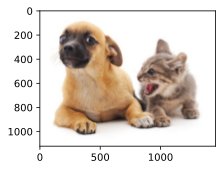

In [16]:
#定义转置卷积
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
#双线性插值核初始化转置卷积核
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

img = torchvision.transforms.ToTensor()(d2l.Image.open('D:\\chrome_file_download\\d2l-zh (1)\\tensorflow\\img\\catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

#图片真的被放大了
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [17]:
#用双线性插值的上采样初始化转置卷积层。对于1×1卷积层，我们使用Xavier初始化参数
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## 读取数据集

In [18]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


## 训练

In [ ]:
#损失函数和之前的不一样，图像分类每一个样本的损失是一个值，图像分割是每一个像素的损失，所以最后要在高和宽两个方向上做一个均值，最后得到一个损失值
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 预测

In [ ]:
def predict(img):
    #将输入图像在各个通道做标准化，然后再转化成神经网络所需要的四维输入格式
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    #每个像素都有21个通道，所以在通道上做argmax,最后出来就是每个像素的label
    pred = net(X.to(devices[0])).argmax(dim=1)
    #跟原图高宽一样的矩阵
    return pred.reshape(pred.shape[1], pred.shape[2])

## 可视化预测的类别

In [ ]:
#将预测类别映射回它们在数据集中的标注颜色
def label2image(pred):
    #把每个类别的RGB做成一个tensor
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    #预测的类别值做成一个index
    X = pred.long()
    return colormap[X, :]

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    #从左上角开始裁剪
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

In [9]:
x=torch.tensor([[1,2,3,4],[5,6,7,8],[9,0,1,2]])
y=x.long()
print(x[2:,:])
print(y)

tensor([[9, 0, 1, 2]])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 0, 1, 2]])


tensor([[  0,   0,   0],
        [128,   0,   0],
        [  0, 128,   0],
        [128, 128,   0],
        [  0,   0, 128],
        [128,   0, 128],
        [  0, 128, 128],
        [128, 128, 128],
        [ 64,   0,   0],
        [192,   0,   0],
        [ 64, 128,   0],
        [192, 128,   0],
        [ 64,   0, 128],
        [192,   0, 128],
        [ 64, 128, 128],
        [192, 128, 128],
        [  0,  64,   0],
        [128,  64,   0],
        [  0, 192,   0],
        [128, 192,   0],
        [  0,  64, 128]])
tensor([[[128,   0,   0],
         [  0, 128,   0],
         [128, 128,   0],
         [  0,   0, 128]],

        [[128,   0, 128],
         [  0, 128, 128],
         [128, 128, 128],
         [ 64,   0,   0]],

        [[192,   0,   0],
         [  0,   0,   0],
         [128,   0,   0],
         [  0, 128,   0]]])


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

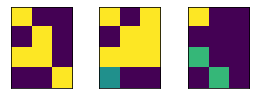

In [19]:
#测试label2image函数里面的语句
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
colormap = torch.tensor(VOC_COLORMAP)
pred=torch.tensor([[1,2,3,4],[5,6,7,8],[9,0,1,2]])
print(colormap)
print(colormap[pred,:])
d2l.show_images(colormap[pred,:],1,3)